In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from geo_tool import Point_Cloud

import tf_lab.autopredictors.scripts.minhyuk_data as minhyuk_data
from tf_lab.autopredictors.scripts.minhyuk_data import KinectData
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import unpickle_data

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
incomplete_n_samples = 2048
complete_n_samples = 4096
normalize_data = True
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

ae_loss = 'chamfer'

# category_name = assembly_chairs or coseg_chairs or airplanes or shapenet_tables
category_name = 'shapenet_tables'  

# ae_type = 'chair', or 'table', or 'all_classes_in_dai'
ae_type = 'table' 

In [4]:
gt_pclouds, gt_names = minhyuk_data.groundtruth_point_clouds(category_name, complete_n_samples)
m_completions, gt_names_2 = minhyuk_data.minhyuk_completions(category_name, complete_n_samples)
partial_pclouds, gt_names_3 = minhyuk_data.incomplete_point_clouds(category_name, incomplete_n_samples)

assert(np.alltrue(gt_names == gt_names_2))
assert(np.alltrue(gt_names == gt_names_3))

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


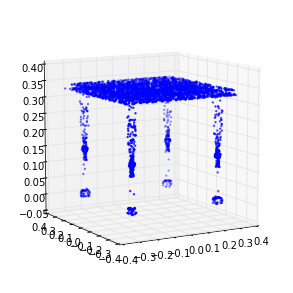

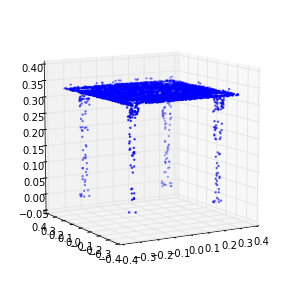

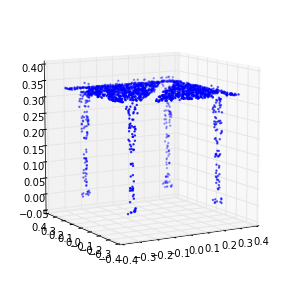

In [5]:
# RUN to see gt-completion-partial triplets are aligned.
rid = np.random.randint(len(gt_pclouds))
Point_Cloud(gt_pclouds[rid]).plot();
Point_Cloud(m_completions[rid]).plot();
Point_Cloud(partial_pclouds[rid]).plot();

In [28]:
rot_degrees = minhyuk_data.rotation_degrees[category_name]

if normalize_data:
    _, partial_pclouds_tr = minhyuk_data.normalize_point_clouds(gt_pclouds, partial_pclouds, rot_degrees)    
    gt_pclouds_tr, m_completions_tr = minhyuk_data.normalize_point_clouds(gt_pclouds, m_completions, rot_degrees)

# if normalize_data:
#     _, partial_pclouds = minhyuk_data.normalize_point_clouds(gt_pclouds, partial_pclouds, category_name)
#     gt_pclouds, m_completions = minhyuk_data.normalize_point_clouds(gt_pclouds, m_completions, category_name)

In [7]:
def accuracy_coverage_stats(gt_pclouds, predictions, thres=0.02):
    n_examples = gt_pclouds.shape[0]
    scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = gt_pclouds[i]
        pred = predictions[i]
        scores[i, 0] = accuracy_of_completion(pred, gt, thres=thres, ret_dists=False)
        scores[i, 1] = coverage_of_completion(gt, pred, thres=thres, ret_dists=False)

    return scores

In [26]:
sung_pred_scores = accuracy_coverage_stats(gt_pclouds_tr, m_completions_tr)
print 'Accuracy: Mean %.3f, Median %.3f' % (np.mean(sung_pred_scores[:, 0]), np.median(sung_pred_scores[:, 0]))
print 'Coverage: Mean %.3f, Median %.3f' % (np.mean(sung_pred_scores[:, 1]), np.median(sung_pred_scores[:, 1]))

Accuracy: Mean 0.910, Median 0.958
Coverage: Mean 0.724, Median 0.717


In [9]:
predictor_name = ae_type + '_2048_4096pts_' + ae_loss + '_original'
predictor_train_dir = osp.join(top_data_dir, 'OUT/iccv/nn_models/', predictor_name)

best_epoch, val_loss = unpickle_data(osp.join(predictor_train_dir, 'validation_stats.pickle'))

conf = Conf.load(osp.join(predictor_train_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(predictor_name, conf)
ae.restore_model(predictor_train_dir, best_epoch, verbose=True)

Model restored in epoch 39.


In [29]:
test_data = PointCloudDataSet(gt_pclouds_tr, labels=gt_names, noise=partial_pclouds_tr, init_shuffle=False)
ae_pred, loss, feed, ids, gt = ae.evaluate(test_data, conf)

In [30]:
our_pred_scores = accuracy_coverage_stats(gt_pclouds_tr, ae_pred)
print 'Accuracy: Mean %.3f, Median %.3f' % (np.mean(our_pred_scores[:, 0]), np.median(our_pred_scores[:, 0]))
print 'Coverage: Mean %.3f, Median %.3f' % (np.mean(our_pred_scores[:, 1]), np.median(our_pred_scores[:, 1]))

Accuracy: Mean 0.732, Median 0.805
Coverage: Mean 0.704, Median 0.711


chair001


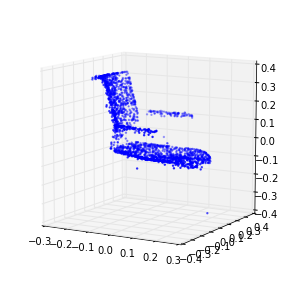

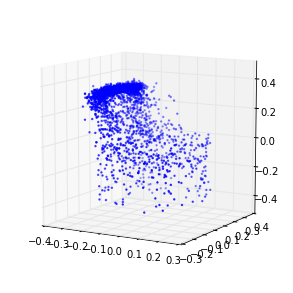

chair002


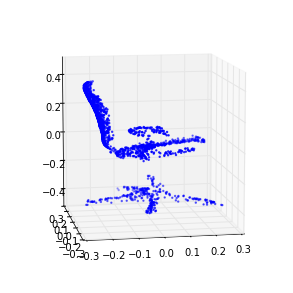

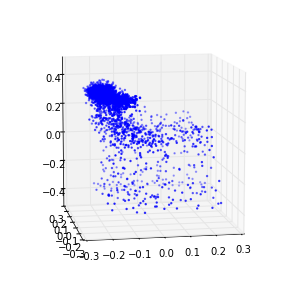

chair003


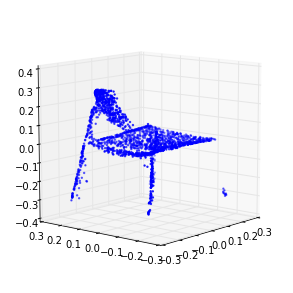

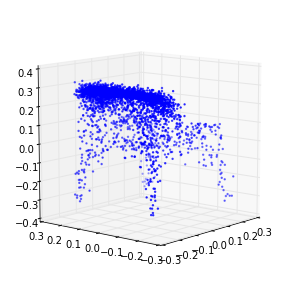

chair006


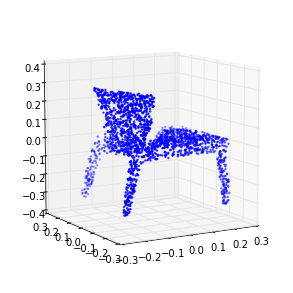

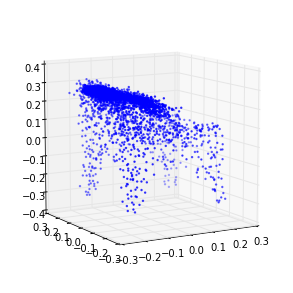

table002


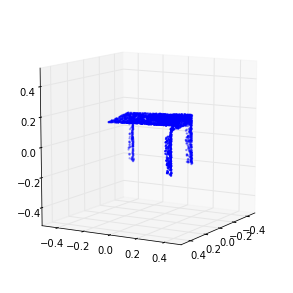

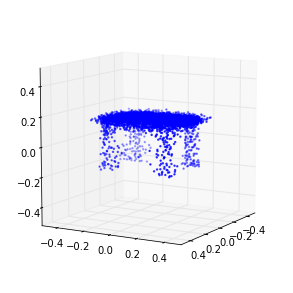

table004


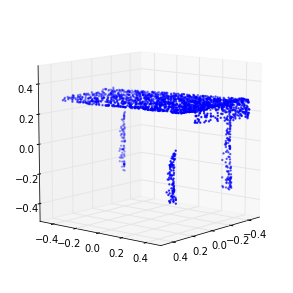

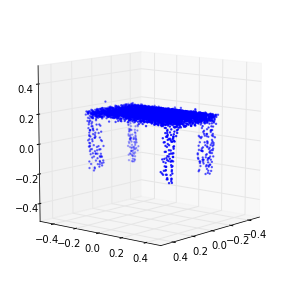

([array([[-0.01503366, -0.17605432, -0.04256925],
         [-0.12741908,  0.04398588,  0.08625376],
         [-0.13797666, -0.14914661,  0.31817472],
         ..., 
         [-0.05674768, -0.13697151, -0.03946027],
         [ 0.19899564,  0.17321866, -0.08319825],
         [-0.10469669, -0.16909147,  0.00557375]]),
  array([[-0.06743662, -0.19671657, -0.00768595],
         [-0.05553904, -0.21115733, -0.03388597],
         [ 0.13113811,  0.00756812,  0.01034404],
         ..., 
         [-0.18355535,  0.05774837,  0.05572204],
         [-0.25266586,  0.03932536,  0.39113106],
         [-0.20772449,  0.07127021,  0.22857405]]),
  array([[ 0.17195835, -0.09354555,  0.01338638],
         [-0.16073411,  0.18605101,  0.08663238],
         [ 0.20087795, -0.21530071, -0.27909041],
         ..., 
         [ 0.04223264, -0.16936894,  0.00946839],
         [ 0.0976955 ,  0.10379123,  0.0177464 ],
         [-0.17212061,  0.00547126,  0.16351338]]),
  array([[-0.20463554, -0.18016167, -0.2320247 ],

In [33]:
from general_tools.in_out.basics import create_dir
pred_out_dir = create_dir(osp.join(top_data_dir, 'OUT/iccv/real_world_data_predictions/sung_data', ae_loss, 'ae_' + ae_type))
KinectData.make_predictions(ae, save_top_dir=pred_out_dir)

In [32]:
# Question: Lin are the rotation angles and the (no) scaling optimal for our generated results?

class KinectData(object):
    '''Real Scan (Kinect) Data used by Sung.
    '''

    top_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Point_Clouds/Partial_PCs/Minhyuk_SigAsia_15/kinect_scan_data/'
    model_names = ['chair001', 'chair002', 'chair003', 'chair006', 'table002', 'table004']

    # Pre-processing for NN (i.e., rotate and swap axis)
    rotation_angles = np.array([-95, -145, 140, 39, 40, 60])
    perm = np.array([[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [1, 0, 2], [1, 0, 2]])

    # Info for Visualization
    azimuth_angles = np.array([300, 260, 220, 240, 30, 40])
    in_u_s = [False, False, False, False, True, True]

    @classmethod
    def make_predictions(cls, nn_model, save_top_dir=None, draft_plot=True):
        incomplete_pclouds = []
        complete_pclouds = []
        incomplete_n_samples = nn_model.n_input[0]
        
        for i, name in enumerate(cls.model_names):            
            print name
                    
            file_name = osp.join(cls.top_dir, name + '_input.ply')
            pc, _ = Point_Cloud(ply_file=file_name).sample(incomplete_n_samples)
            pc.permute_points(cls.perm[i])
            pc.rotate_z_axis_by_degrees(cls.rotation_angles[i])
            pc.center_axis()
            incomplete_pclouds.append(pc.points)
            if save_top_dir is not None:
                pc.save_as_ply(osp.join(save_top_dir, 'incomplete_' + name) )
            
            recon = nn_model.reconstruct(pc.points.reshape(1, incomplete_n_samples, 3), compute_loss=False)[0]            
            recon = Point_Cloud(points=np.squeeze(recon))
            complete_pclouds.append(recon.points)
            if save_top_dir is not None:
                recon.save_as_ply(osp.join(save_top_dir, 'predicted_' + name) )
            
            if draft_plot:
                pc.plot(azim=cls.azimuth_angles[i], s=8, in_u_sphere=cls.in_u_s[i])
                recon.plot(azim=cls.azimuth_angles[i], s=8, in_u_sphere=cls.in_u_s[i])
        
        return incomplete_pclouds, complete_pclouds